## Predicated solid earth tide

Based on the `solid` fortran code by Dennis Milbert: http://geodesyworld.github.io/SOFTS/solid.htm.

#### To-do list
+ resize the corase grid to the same 
+ Pass matrix from fortran to python (get the pointer from fortran to python and use np.frombuffer) - Piyush
   - https://github.com/isce-framework/fringe/blob/master/include/fringe/EigenLapack.hpp

In [1]:
%matplotlib inline
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from mintpy import view
import solid
plt.rcParams.update({'font.size': 12})
figsize = [9, 3]

box = (10, 55, 20, 70);   box_suffix = 'boxCL'   # box in the center left with low  altitude
#box = (85, 25, 145, 70);  box_suffix = 'boxCC'   # box to read for range offset in (x0, y0, x1, y1)
box = (200, 15, 215, 30); box_suffix = 'boxLR'   # box in the lower right with high altitude

proj_dir = '/Users/yunjunz/data/ChileSenAT149'
os.chdir(proj_dir)
print('Go to directory', proj_dir)

out_file = os.path.join(proj_dir, 'offset_comp', box_suffix, 'set.pickle')

Go to directory /Users/yunjunz/data/ChileSenAT149


### 1. calc solid earth tide from `solid`

update mode: ON
skip re-calculating and use existing file: /Users/yunjunz/data/ChileSenAT149/mintpyOffset/geo/geo_SET.h5
Done.


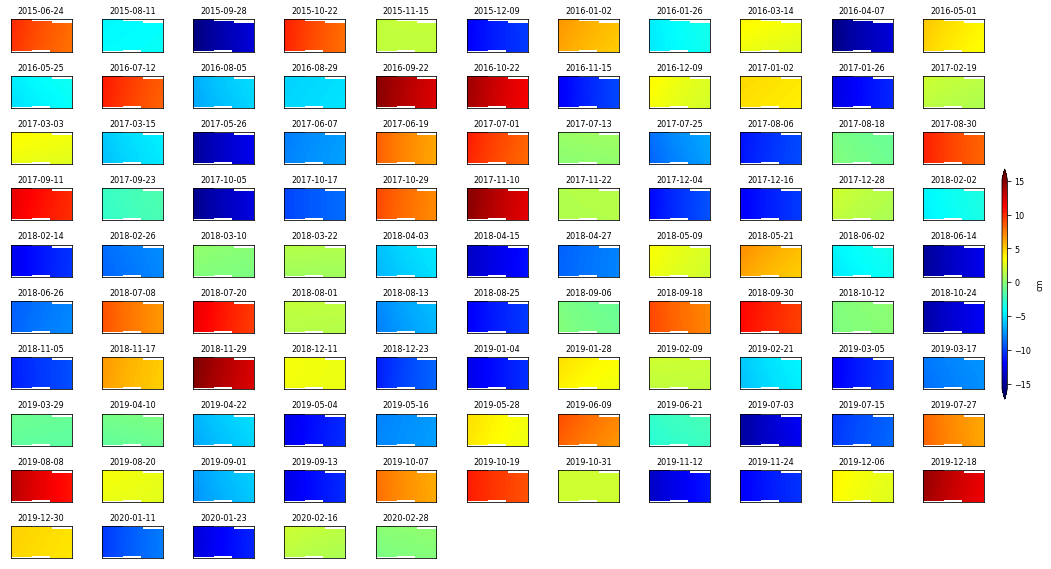

In [2]:
ts_file   = os.path.join(proj_dir, 'mintpyOffset/timeseriesRg.h5')
geom_file = os.path.join(proj_dir, 'mintpyOffset/inputs/geometryRadar.h5')
set_file  = os.path.join(proj_dir, 'mintpyOffset/inputs/SET.h5')
update_mode = True

# get geometry file in geo-coordinates
geo_geom_file = os.path.join(proj_dir, 'mintpyOffset/geo/geo_geometryRadar.h5')
if not update_mode or not os.path.isfile(geo_geom_file):
    scp_name = os.path.expandvars('${MINTPY_HOME}/mintpy/geocode.py')
    cmd = '{s} {g} -l {g} -o {o}'.format(s=scp_name, g=geom_file, o=geo_geom_file)
    !{cmd}

# get solid earth tide in geo-coordinates
date_list = timeseries(ts_file).get_date_list()
geo_set_file = solid.get_solid_earth_tide_timeseries(date_list, geo_geom_file, update_mode=update_mode)

# solid earth tide: geo2radar
if not update_mode or not os.path.isfile(set_file):
    scp_name = os.path.expandvars('${MINTPY_HOME}/mintpy/geocode.py')
    cmd = '{s} {g} -l {l} -o {o} --geo2radar'.format(s=scp_name, g=geo_set_file, l=geom_file, o=set_file)
    !{cmd}
print('Done.')

# display
view.main([set_file, '--noverbose'])

### 2. save to pickle file

In [3]:
# read data
num_date = len(date_list)
ts_data = readfile.read(set_file, box=box)[0].reshape(num_date, -1)

# compose set dict
sDict = {}
sDict['date'] = np.array(date_list)
sDict['time'] = np.array(ptime.date_list2vector(date_list)[0])
sDict['range_delay_SET_med'] = np.nanmedian(ts_data, axis=-1)
sDict['range_delay_SET_mad'] = ut.median_abs_deviation(ts_data)

# save to pickle file
os.makedirs(os.path.dirname(out_file), exist_ok=True)
with open(out_file, 'wb') as f:
    pickle.dump(sDict, f)
    print('save data to file: {}'.format(out_file))

save data to file: /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/set.pickle


### 3. Plot

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/set.png


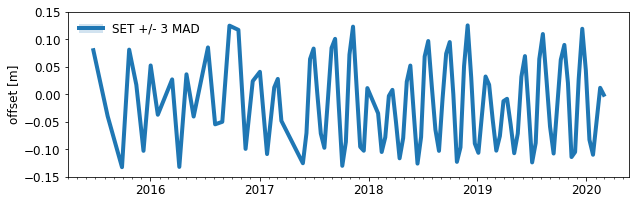

In [4]:
key_base = 'range_delay_SET'
n = 3

x = sDict['time']
y = sDict[key_base+'_med']
y_err = sDict[key_base+'_mad'] * n

fig, ax = plt.subplots(figsize=figsize)
p0, = ax.plot(x, y, linewidth=4, color='C0')
p1  = ax.fill_between(x, y - y_err, y + y_err, fc='C0', ec='none', alpha=0.2)

# axis format
pp.auto_adjust_xaxis_date(ax, x, every_year=1, buffer_year=None)
ax.set_ylabel('offset [m]')
ax.set_ylim(-0.15, 0.15)
ax.legend([(p0, p1)], ['SET +/- {} MAD'.format(n)], frameon=False)
fig.tight_layout()

# output
out_fig = os.path.join(os.path.dirname(out_file), 'set.png')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()